In [4]:
from functools import partial
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as c
import sympy as sp
import scipy.optimize as op
from matplotlib import image

In [5]:
#Parameters 
b = 10
p = 0.5
a0= 0.01
W0 = 1
q0 = 0.005
zb = 10
hs = 0.1
hf = 0.2
rs = r = 0.5
rf = 0.5
ls = 0.5
lf = 0.2

maxl = 0.05
minl = 0.1
pl =10
zt = 2

In [6]:
#Defining functions

def a(z,zm): #Shading effect
    a = 2*a0 * np.exp(b*(z-zm))/(1+np.exp(b*(z-zm)) )
    return(a)

def q(z):  #Nutrients impact
    q = q0* np.exp(p*z)
    return q

def W(z): #Light attenuation
    W = W0*np.exp(w*z)- W0
    return W

def Ls(z) : #Mortality of submerged 
    res = maxl -(maxl-minl)*zt**pl/(z**pl + zt**pl)
    return res

def Lf(z) : #Mortality of floating 
    res = minl -(minl-maxl)*zt**pl/(z**pl + zt**pl)
    return res

def nm(zm, z,zf, S,F,Sm, Nu0, u):  #Nutrient availability for mutant
    res = Nu2(zm,Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def n(z,zf, zm, S,F,Sm, Nu0, u):  #Nutrient availability for submerged
    res = Nu2(z, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def nf(z,zf, zm, S,F,Sm,Nu0, u):  #Nutrient availability for floating
    res = Nu2(zf, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def Nu(z,Nu0, u):  #Nutrient concentration
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def f(pop,t,z,zf,zm,Nu0,u):  #Main system function (EDO)
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  r*S*n2(z,zf,zm,S,F,Sm, Nu0, u)/(n2(z,zf,zm,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,zf)*F+W(z)) - Ls(z) *S
    f1 =  r*F*nf2(z,zf,zm,S,F,Sm, Nu0, u)/(nf2(z,zf,zm,S,F,Sm, Nu0, u) + hf)* 1/(1+ a(zf,z)*S+a(0,0)*F+W(zf)) - Lf(zf)*F
    f2= r*Sm*nm2(zm,z,zf,S,F,Sm, Nu0, u)/(nm2(zm,z,zf,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm)*Sm
    f = [f0, f1,f2]
    return f


def F2(POP,z, Nu0, u): #Main function 2 (without mutant)
    S = POP[0]
    F = POP[1]
    f0 =  rs*S*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z) *S
    f1 =  rf*F*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0) *F
    f = [f0, f1]
    return f

def jacF2(z, S,F, Nu0, u): #Jacobian
    a1 = -rs*Nu(z)*S*( ( hs*q(z)*( 1 + a0*S +a(z,0)*F +W(z)) + a0*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  ) + r*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z)
    b1 = -rs*Nu(z)*S*( ( hs*q(0)*( 1 + a0*S +a(z,0)*F +W(z)) + a(z,0)*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  )
    d1 = -rf*Nu(0)*F*( ( hf*q(0)*( 1 + a0*F ) + a0*(Nu(0)+ hf*(1+ q(0)*F +q(z) *S))) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  ) + r*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0)
    c1 = -rf*Nu(0)*F*( ( hf*q(z)*( 1 + a0*F ) ) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  )
    
    jac = np.array([[a1,b1], [c1,d1]])
     
    return jac 

In [10]:
Nu_val = np.linspace(0.5,100,100)
u_val = np.linspace(0.1,10,100)
zm_val = np.linspace(0,zb,200)
zf_val = np.linspace(0,5,200)
X, Y = np.meshgrid(Nu_val, u_val)

In [11]:
Nu0= 50
zm = zfm = 5
b = 10
w = 0.1 
u = 7

In [12]:
popF = np.eye(200) 
popS = np.eye(200) 

for i in range(200):
    z = zm_val[i] 
    F= S = 100
    for j in range(200): 
        zf = zf_val[j]  
        traj = odeint(partial(f2, z=z, zm=zm, zf=zf, Nu0 = Nu0, u =u), y0= [S+0.1, F+0.1, 0], t=time)
        S =  traj[-1,0] 
        F = traj[-1,1]
        popS[i,j] = S
        popF[i,j] = F 

In [13]:
popF2 = np.eye(200) 
popS2 = np.eye(200) 

for i in range(200):
    F= S = 100
    z = zm_val[i] 
    for j in range(200): 
        zf = zf_val[199-j]
        traj = odeint(partial(f2, z=z, zm=zm, zf=zf,Nu0 = Nu0, u =u), y0= [S+1, F+1, 0], t=time)
        S =  traj[-1,0] 
        F = traj[-1,1]
        popS2[i,199-j] = S
        popF2[i,199-j] = F

In [14]:
coex = np.eye(200)
for i in range(200):
    for j in range(200): 
            if popF[i,j] > 10:
                if popS[i,j] > 10:
                    coex[i,j] =4 
                else:
                    coex[i,j] = 1
            else:
                if popS[i,j] > 10:
                    coex[i,j] = 2
                else:
                    coex[i,j] = 0

In [15]:
for i in range(200):
    for j in range(200): 
            if (popF[i,j] > 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] > 1) or (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] > 1) : 
                coex[i,j] = 5
            elif (popF[i,j] > 0 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] < 1) or  (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] < 1) : 
                coex[i,j] = 3
            elif (popF[i,j] < 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] < 1) or (popF2[i,j] < 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] < 1) : 
                coex[i,j] = 6

In [17]:
import matplotlib.patches as mpatches
plt.figure(1)
colors = np.genfromtxt(fname='colors.txt')
colors = colors[1:]
my_cmap = plt.matplotlib.colors.ListedColormap(colors, name='from_list', N=None)
im = plt.imshow(coex,cmap=my_cmap,extent =[0, 5, 10,0],aspect='auto')


plt.xlabel('Floating plants depth trait (zf)')
plt.ylabel('Submerged plants depth trait (zs)')

plt.show()

2.5

In [22]:
from scipy.misc import derivative

def taux_fm(zfm,z, zm,zf, S,F):
    taux = r*nfm2(z,zf,zfm, zm, S,F,0,Nu0, u)/(nfm2(z,zf,zfm, zm, S,F,0,Nu0, u) +hf)* 1/(1+ a(zfm,zf)*F+ a(zfm,z)*S+W(zfm)) - Lf(zfm)
    return taux

def GradF2(z,zm,zf,zfm, Nu0, u):
    j = np.where(zf_val >= zf)[0][0]
    k = np.where(zm_val >= z)[0][0]
    S = popS[k,j]
    F = popF[k,j] 
    der = derivative(partial(taux_fm, z=z,zm=zm,zf=zf, F=F, S=S), zfm, dx=10e-6)
    return der

In [23]:
H = 1e-6
def taux_sm(zm, z,zf,zfm, S,F):
    taux = r*nm2(zm, z,zf, S,F,0, Nu0, u)/(nm2(zm, z,zf, S,F,0, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+ a(zm,zf)*F+W(zm)) - Ls(zm) 
    return taux

def GradF(zm,z,zf,zfm, Nu0, u):
    j = np.where(zf_val >= zf)[0][0]
    k = np.where(zm_val >= z)[0][0]
    S = popS[k,j]
    F = popF[k,j] 
    der = derivative(partial(taux_sm, z=z,zf=zf,zfm=zfm, F=F, S=S), zm, dx=10e-6)
    return der

In [25]:
GradF_F = np.eye(200) 
zf = zfm = 0 
for i in range(200) : 
    z = zm_val[i]
    for j in range(200) :
        zf = zf_val[j]
        res = GradF2(z,z,zf,zf, Nu0, u) 
        if res < 0 : 
            res = -1
        elif res == 0 : 
            res = 0
        else : 
            res = 1
        GradF_F[i,j] = res

In [26]:
GradF_S = np.eye(200) 
zf = zfm = 0 
for i in range(200) : 
    z = zm_val[i]
    for j in range(200) :
        zf = zf_val[j]
        res = GradF(z,z,zf,zf, Nu0, u) 
        if res < 0 : 
            res = -1
        elif res == 0 : 
            res = 0
        else : 
            res = 1
        GradF_S[i,j] = res

In [27]:
final = np.eye(200)
for i in range(200) : 
    for j in range(200) :
        if GradF_S[i,j] == -1 : 
            if GradF_F[i,j] == -1 : 
                final[i,j] = -2
            else : 
                final[i,j] = -1
        else : 
            if GradF_F[i,j] == -1 : 
                final[i,j] = 0
            else : 
                final[i,j] = 2

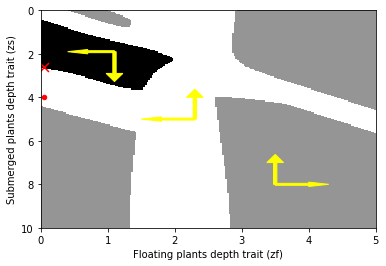

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(final,cmap='Greys', extent =[0, 5, 10,0],aspect='auto')
ax.autoscale(False)
plt.xlabel('Floating plants depth trait (zf)')
plt.ylabel('Submerged plants depth trait (zs)')
plt.arrow(3.5, 8, 0.5,0,color='yellow',head_width = 0.2,width=0.09)
plt.arrow(3.5, 8, 0,-1,color='yellow',head_width = 0.25,width=0.05)

plt.arrow(2.3, 5, -0.5,0,color='yellow',head_width = 0.2,width=0.09)
plt.arrow(2.3, 5, 0,-1,color='yellow',head_width = 0.25,width=0.05)

plt.arrow(1.1, 1.9, -0.4,0,color='yellow',head_width = 0.2,width=0.09)
plt.arrow(1.1, 1.9, 0,1,color='yellow',head_width = 0.25,width=0.05)

plt.scatter(0.04,2.6, c='r', marker = 'x', s=80)
plt.scatter(0.04,4, c='r', marker = '.', s=80)

In [121]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


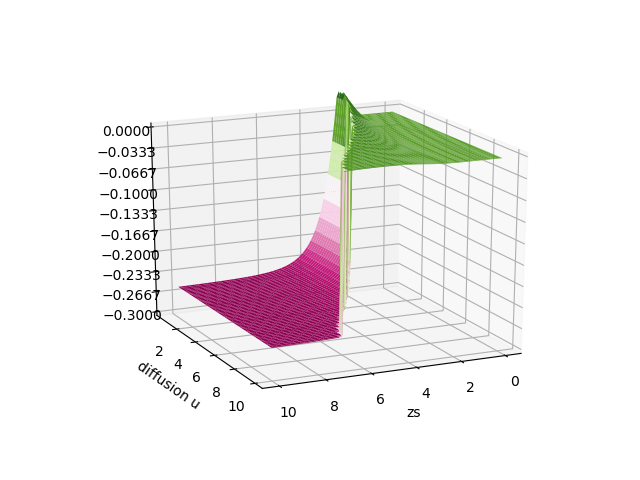

In [140]:
%matplotlib notebook


fig2 = plt.figure(1)
ax2 = fig2.add_subplot(projection='3d')
surf2 = ax2.plot_surface(X, Y, Zf, cmap=cm.PiYG)

plt.xlabel('zs')
plt.ylabel('diffusion u')

ax1.set_zlim(-0.5, 0.1)
ax1.zaxis.set_major_locator(LinearLocator(10))

ax2.set_zlim(-0.3, 0)
ax2.zaxis.set_major_locator(LinearLocator(10))


for angle in range(0, 360):
    ax1.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
for angle in range(0, 360):
    ax2.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()

In [204]:
def test(traits) : 
    z = traits[0]
    zf = traits[1]
    a1 = GradF(z,z,zf,zf,Nu0,u)
    a2 = GradF2(z,z,zf,zf,Nu0,u)
    return[a1,a2]

In [205]:
def sol(fonction) : 
    sol = [0,0]
    for i in range(99) : 
        for j in range(99) :
            x = zm_val[i]
            x2 = zm_val[i+1]
            xf= zf_val[j]
            xf2 = zf_val[j+1]
            res = np.array([x,xf])
            res2 = np.array([x2,xf2])
            val = fonction(res) 
            val2 = fonction(res2) 
            if  val[0]*val2[0] < 0 and val[1]*val2[1] < 0: 
                sol = [(x2+x)/2, (xf2+xf)/2]
                
    return sol 

In [146]:
def dzdzm(zm,z, Nu0, u):
    der = (GradF(zm,z+H, Nu0, u) - GradF(zm,z, Nu0, u))/H
    return der

def dzmdzm(zm,z, Nu0, u):
    der = (GradF(zm+H,z, Nu0, u) - GradF(zm,z, Nu0, u))/H
    return der

def dz(zm,z, Nu0, u):
    der = (taux_sm(zm,z+H,F,S) - taux_sm(zm,z,F,S))/H
    return der

def dzdz(zm,z, Nu0, u):
    der2 = (dz(zm,z+H,F,S) - dz(zm,z,F,S))/H
    return der2

In [147]:
def dicho(f, a, b, eps=1e-8):
    if f(a)*f(b) > 0 : 
        return 0 
    else :
        while abs(b-a) > eps:    
            c = (a+b)/2
            if f(a)*f(c) >= 0:
                a=c
            else:
                b=c
        return b  

def grad(z):
    return GradF(z,z, Nu0, u)

def grad2(z):
    return GradF2(z,z, Nu0, u)

In [148]:
singP = np.zeros(100)

for i in range(100):
    u = u_val[i]
    sing = dicho(grad,0,10)
    singP[i]= sing

In [159]:
stra= np.zeros(100)
for n in range(1,100) : 
    u = u_val[n]
    z = singP[n] 
    j = np.where(u_val >= u)[0][0]
    k = np.where(zm_val >= z)[0][0]
    
    S = SS[k,j]
    F = FF[k,j]
    ess = dzmdzm(z, z, Nu0, u)
    css  = ess + dzdzm(z,z, Nu0, u)
    c11 = dzdz(z,z,Nu0,u)
    if ess < 0 : 
        if css < 0 : 
            stra[n] = 4
        else : 
            stra[n] = 1
    elif css < 0  : 
        stra[n] = 3

In [189]:
def g(Z , t):
    z = Z[0]
    zf = Z[1]
    j = np.where(zf_val >= zf)[0][0]
    k = np.where(zm_val >= z)[0][0]
    if coex[k,j] == 5 or coex[k,j] == 3 : 
        S = popS2[k,j]
        F = popF2[k,j] 
    else : 
        S = popS[k,j]
        F = popF[k,j]
    dz = 1/2 * mu* amp**2 * S * GradF(z,z,zf,zf, Nu0, u)
    dz2 = 1/2 * mu* amp**2 * F * GradF2(z,z,zf,zf, Nu0, u)
    res = [dz,dz2]
    return res

In [190]:
test = odeint(g, y0= [6,2], t=time)